In [1]:
#1 加载必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision  import datasets, transforms

In [2]:
#2 定义超参数
BATCH_SIZE = 16 #每批处理的数据
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10 # 训练数据集的轮次


In [3]:
#3 构建pipeline, transform 对数据作处理
pipeline=transforms.Compose([
    transforms.ToTensor(),#
    transforms.Normalize((0.1307,0),(0.3081,))#正则化，降低模型复杂度，计算量，过拟合
])

In [4]:
#4 下载、加载数据
from torch.utils.data import DataLoader

#下载数据
train_set = datasets.MNIST("data",train=True,download=True,transform=pipeline)
test_set = datasets.MNIST("data",train=False,download=True,transform=pipeline)

#加载数据

train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

/home/sun/.pyenv/versions/DataVisualization/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
with open("./data/MNIST/raw/train-images-idx3-ubyte","rb") as f:
    file=f.read()

In [6]:
imagel=[int(str(item).encode('ascii'),16) for item in file[16:16+784]]
#print(imagel.shape)

(784,)
(28, 28, 1)


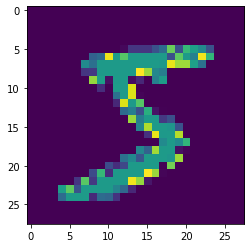

In [7]:
import matplotlib.pyplot as plt
import numpy as np
print(np.array(imagel).shape)
imagel_np=np.array(imagel,dtype=np.uint8).reshape(28,28,1)
plt.imshow(imagel_np)
print(imagel_np.shape)

In [8]:
#5 构建网络模型
class Digit(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,10,5)#灰度
        self.conv2=nn.Conv2d(10,20,3)
        self.fc1=nn.Linear(20*10*10,500)
        self.fc2=nn.Linear(500,10)
    
    def forward(self,x):
        input_size=x.size(0) # batch_size,1->灰度,28*28->像素
        x=self.conv1(x) #输入：batch_size*1*28*28,输出：batch_size*10*24*24 (28-5+1)
        x=F.relu(x)
        x=F.max_pool2d(x,2,2) #输入: batch_size*10*24*24, 输出:batch_sze*10*12*12
        
        x=self.conv2(x)#输出batch * 20*10*10
        x=F.relu(x)
        
        x=x.view(input_size,-1)#输出batach * 20*10*10
        
        x=self.fc1(x) #输入 batch * 2000, 输出：batch * 500
        x=F.relu(x)
        
        x=self.fc2(x)
        output=F.log_softmax(x,dim=1)
        
        return output
            
        

In [9]:
#6 定义优化器 
model=Digit().to(DEVICE)
optimizer=optim.Adam(model.parameters())


In [10]:
print(train_loader.dataset.data.shape)
print(train_loader.dataset.targets)

torch.Size([60000, 28, 28])
tensor([5, 0, 4,  ..., 5, 6, 8])


In [19]:
#7 定义训练方法
def train_model(model,device,train_loader, optimizer, epoch):
    model.train()
    print(train_loader)
    print(next(iter(train_loader)))
    #for batch_index, (data, target) in enumerate(train_loader):
    for batch_index, (data, target) in enumerate(train_loader):
        # employ data to device
        data,target=data.to(device),target.to(device)
        # initilize parameters
        optimizer.zero_grad()
        # forward calculate
        output = model(data)
        # calculate cost
        loss = F.cross_entropy(output,target)        
        loss.backward()
        #
        optimizer.step()
        if batch_index %3000 ==0:
            print("train epoch: {}\t Loss:{:.6f}\f".format(epoch, loss.item()))
        
        
        
        
        

In [15]:
#8 定义测试方法
def test_model(model, device,test_loader):
    #evaluate model
    model.eval()
    correct=0.0
    test_loss=0.0
    with torch.no_grad():
        for data, target in test_loader:
            data,target = data.to(device),target.to(device)
            
            output=model(data)
            test_loss+=F.cross_entropy(output,target).item()
            pred=output.max(axis=1,keepdim=True)[1]
            
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        print("test --- Average loss: {:.4f}. Accurary: {:.3f}\n".format(test_loss, 100*corret/len(test_loader.dataset)))
            
            
            


In [20]:
for epoch in range(1, EPOCHS,+1):
    train_model(model,DEVICE,train_loader,optimizer,epoch)
    test_model(model,DEVICE,test_loader)

RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [2, 28, 28]